# Example Problem

Example 4.1. Suppose a wheel is rotating on an axle, the total moment of inirtia being $J$, 
and it is required to bring the system to rest by applying a braking torque $u(t)$. 
The equation of motion is

\begin{equation}
    J\frac{dx}{dt} = u 
\end{equation}



In [48]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

In [49]:
x = torch.cuda.current_device()
x

0

In [50]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [52]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.Hidden_layer = nn.Linear(in_features=1,out_features=10)
        self.Output_layer = nn.Linear(in_features=10,out_features=1,bias=False)
        self.Sigmoid = nn.Sigmoid()

    def forward(self,x):
        x = self.Hidden_layer(x)
        x = self.Sigmoid(x)
        output = self.Output_layer(x)
        return output

In [53]:
NeuralNetwork()

NeuralNetwork(
  (Hidden_layer): Linear(in_features=1, out_features=10, bias=True)
  (Output_layer): Linear(in_features=10, out_features=1, bias=False)
  (Sigmoid): Sigmoid()
)

## Method

Now we will take t in [0,1] and construct x_trial and solve using neural network and use that x_trial
to find the u_t_trial and compare it with u_t from analytical solution we have for our initial conditions

Lets take J = 10, and x(0) = 10 and we want x(1) = 0.

ODE: 

\begin{equation}
    \frac{dx}{dt} = \frac{u}{J}
\end{equation}

Converting it to find u(t),

\begin{equation}
    u(t) = J\frac{dx}{dt}
\end{equation}

Where

- $ x(t) $ is angular velocity.
- $ J $ is total moment of inertia.
- $ u(t) $ is breaking torque.


Let

\begin{equation}
    t \in [0,1]
\end{equation}

\begin{equation}
    J = 10
\end{equation}

\begin{equation}
    x(0) = 10 
\end{equation}

\begin{equation}
    x(1) = 0
\end{equation}


Exact (actual) solution of above ODE is:

\begin{equation}
    u_a(t) = \frac{-J x(t_0)}{t_1-t_0}
\end{equation}

for above initial condtions,

\begin{equation}
    u_a(t) = -100
\end{equation}


Trail solution is of the form:

\begin{equation}
    x(t)_{tr} = A(1-t) + Bt + t (1-t) N(t,p)
\end{equation}

But, $ A = x(0) = 10 $ , $ B = x(1) = 0 $ therefore the final trial equation of x becomes,

\begin{equation}
    x(t)_{tr} = 10(1-t) + t (1-t) N(t,p)
\end{equation}


\begin{equation}
    u(t)_{tr} = J \frac{d}{dt} x_{tr}
\end{equation}


In [54]:
# For Example Problem 1 Only

def u_exact(J,x_0,t):
    return -J*x_0/t[-1]-t[0]

def x_trial(t,N,x_0):
    A = x_0
    B = 0
    return A*(1-t) + B*t + t*(1-t)*N(t)

def u_trail(J,dx_dt):
    return J * dx_dt

def dx_dt_trial(x_t,t):
    t.requires_grad = True
    return torch.autograd.grad(x_t.sum(), t, create_graph=True)[0]

def loss_1(t,J,N,x_0):
    t.requires_grad = True
    x_t = x_trial(t,N,x_0)
    u_a = u_exact(J,x_0,t)

    dx_dt = dx_dt_trial(x_t,t)

    u_tr = u_trail(J,dx_dt)

    G = (u_a - u_tr)**2
    
    return torch.sum(G)

In [55]:
def Optimize(t,J,epochs,N,x_0):

    optimizer = torch.optim.LBFGS(N.parameters())
    
    def train():
        optimizer.zero_grad()
        l = loss_1(t,J,N,x_0)
        l.backward()

        return l

    for _ in tqdm(range(epochs)):
        optimizer.step(train)

In [56]:
def MSE_Calculate(t,J,N,x_0):

    x_t = x_trial(t,N,x_0)
    dx_dt = dx_dt_trial(x_t,t)
    with torch.no_grad():
        
        u_tr = u_trail(J,dx_dt).detach().cpu()
        u_ex = u_exact(J,x_0,t).detach().cpu()
        
    mse = torch.mean((u_tr - u_ex)**2)
    print(f"MSE: {mse}")

In [57]:
def Plot_solutions(t,N,x_0):

    with torch.no_grad():
        x_t = x_trial(t,N,x_0).detach().cpu()
        t = t.detach().cpu()

    plt.figure(figsize=(6, 5))  
    plt.plot(t, x_t, '-', label="Exact", color='darkorange', linewidth=1.5,antialiased=True) 
    
    # Making plot visually good
    plt.xlabel('Time', fontsize=10,fontweight='bold', labelpad=10)  # Increase font size for labels
    plt.ylabel('x(t)', fontsize=10,fontweight='bold', labelpad=10)
    plt.legend(fontsize=10, loc='best', frameon=True)  # Adjust legend font size
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Dashed grid lines
    plt.title('Plot of X(t)', fontsize=12,fontweight='bold', pad=20)  # Add a title
    plt.xticks(fontsize=10)  # Customize x-axis tick size
    plt.yticks(fontsize=10)  # Customize y-axis tick size
    plt.tight_layout()  # Ensure labels and titles fit within the plot
    plt.show()

In [58]:

EPOCHS = 100
J = 10
x_0 = 10

### u_exact = -J*x_0 = -100

T = torch.linspace(start=0,end=1,steps=100).unsqueeze(1).to(device=device)

N = NeuralNetwork().to(device=device)

Optimize(T,J,EPOCHS,N,x_0)
MSE_Calculate(T,J,N,x_0)


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:10<00:00,  9.52it/s]

MSE: 4.1327437999560956e-11


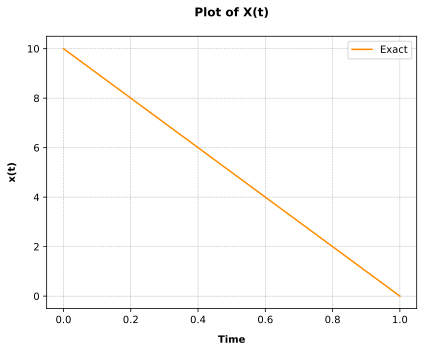

In [59]:
Plot_solutions(T,N,x_0)

We can see that the slope of this is

\begin{equation}
    \frac{dx}{dt} = u / J
\end{equation}